In [53]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.backends import backend_pdf as bpdf
import matplotlib
import pickle
from scipy.special import kl_div
from scipy.optimize import brentq,minimize,LinearConstraint,Bounds,NonlinearConstraint
from scipy.integrate import solve_ivp
%matplotlib inline

# MacArthur's Models (Theor. Pop. Biol. 1, 1970)

## Competition for noninteracting resources

\begin{align}
\frac{dN_i}{dt} &= N_i \left[ \sum_{\alpha} w_\alpha c_{i\alpha} R_\alpha - m_i\right]\\
\frac{dR_\alpha}{dt} &= r_\alpha R_\alpha (R_\alpha^0 - R_\alpha) - \sum_i N_i c_{i\alpha} R_\alpha.
\end{align}

\begin{align}
d(\mathbf{R}^0,\mathbf{R}) &= \frac{1}{2}\sum_\alpha r_\alpha w_\alpha (R_\alpha - R_\alpha^0)^2\\
\sum_{\alpha} w_\alpha c_{i\alpha} R_\alpha &\leq m_i\\
R_\alpha &\geq 0
\end{align}

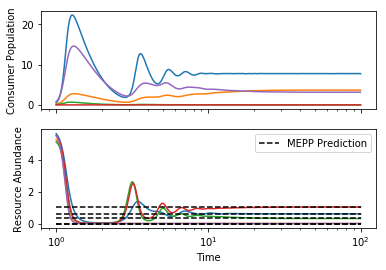

In [42]:
#Parameters
S = 5
M = 5
params = {'c':np.random.rand(S,M),
          'm':np.random.rand(S)+1,
          'w':np.random.rand(M)+1,
          'r':np.random.rand(M)+1,
          'R0':np.random.rand(M)+5}
N_init = np.random.rand(S)
R_init = params['R0']
tmin = 1
tmax= 100

#ODE
def dydt(t,y):
    N = y[:S]
    R = y[S:]
    dNdt = N*((params['c']*params['w']).dot(R)-params['m'])
    dRdt = params['r']*R*(params['R0']-R) - (params['c'].T.dot(N))*R
    return np.hstack((dNdt,dRdt))
out_ODE = solve_ivp(dydt,(tmin,tmax),np.hstack((N_init,R_init)),t_eval=np.logspace(np.log10(tmin),np.log10(tmax),1000))
t = out_ODE.t
N = out_ODE.y[:S,:].T
R = out_ODE.y[S:,:].T

#Constrained optimization
noninvadable = LinearConstraint(params['c']*params['w'],-np.inf*np.ones(S),params['m'])
resource_feasible = Bounds(0,np.inf)
def d(R):
    return ((R-params['R0'])**2*params['w']*params['r']).sum()
out_opt = minimize(d, R_init, method='trust-constr', constraints=noninvadable, bounds=resource_feasible)
Rstar = out_opt.x

fig,ax=plt.subplots(2,sharex=True)
#Plot ODE results
ax[0].semilogx(t,N)
ax[1].semilogx(t,R)
#Plot optimization results
ax[1].plot([t[0],t[-1]],[Rstar,Rstar],'k--')
#Make legend
ax[1].plot([],[],'k--',label='MEPP Prediction')
ax[1].legend()
#Make labels
ax[1].set_xlabel('Time')
ax[0].set_ylabel('Consumer Population')
ax[1].set_ylabel('Resource Abundance')
plt.show()

## Interacting self-regulation

\begin{align}
\frac{dN_i}{dt} &= N_i\left[ \sum_{\alpha} w_\alpha c_{i\alpha} R_\alpha - m_i\right]\\
\frac{dR_\alpha}{dt} &= R_\alpha\left(A - \sum_\beta w_\beta R_\beta \right) -  \sum_i c_{i\alpha} N_i R_\alpha.
\end{align}

\begin{align}
d(\mathbf{R}^0,\mathbf{R}) &=  \frac{1}{2}\left(A - \sum_{\alpha} w_\alpha R_\alpha \right)^2\\
\sum_{\alpha} w_\alpha c_{i\alpha} R_\alpha &\leq m_i\\
R_\alpha &\geq 0
\end{align}

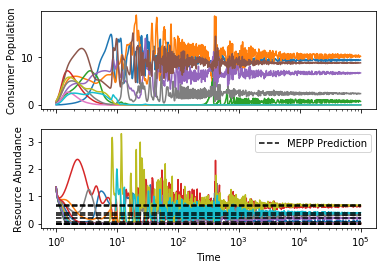

In [34]:
#Parameters
S = 10
M = 15
params = {'c':np.random.rand(S,M),
          'm':np.random.rand(S)+1,
          'w':np.random.rand(M)+1,
          'A':20}
N_init = np.random.rand(S)
R_init = np.ones(M)*params['A']/M
tmin = 1
tmax= 100000

#ODE
def dydt(t,y):
    N = y[:S]
    R = y[S:]
    dNdt = N*((params['c']*params['w']).dot(R)-params['m'])
    dRdt = R*(params['A']-params['w'].dot(R)) - (params['c'].T.dot(N)).T*R
    return np.hstack((dNdt,dRdt))
out_ODE = solve_ivp(dydt,(tmin,tmax),np.hstack((N_init,R_init)),t_eval=np.logspace(np.log10(tmin),np.log10(tmax),1000))
t = out_ODE.t
N = out_ODE.y[:S,:].T
R = out_ODE.y[S:,:].T

#Constrained optimization
noninvadable = LinearConstraint(params['c']*params['w'],-np.inf*np.ones(S),params['m'])
resource_feasible = Bounds(0,np.inf)
def d(R):
    return (params['A'] - params['w'].dot(R))**2
out_opt = minimize(d, R_init, method='trust-constr', constraints=noninvadable, bounds=resource_feasible)
Rstar = out_opt.x

fig,ax=plt.subplots(2,sharex=True)
#Plot ODE results
ax[0].semilogx(t,N)
ax[1].semilogx(t,R)
#Plot optimization results
ax[1].plot([t[0],t[-1]],[Rstar,Rstar],'k--')
#Make legend
ax[1].plot([],[],'k--',label='MEPP Prediction')
ax[1].legend()
#Make labels
ax[1].set_xlabel('Time')
ax[0].set_ylabel('Consumer Population')
ax[1].set_ylabel('Resource Abundance')
plt.show()

## Competition to withstand predators

\begin{align}
\frac{dN_i}{dt} &= N_i \left[ \sum_{\alpha} w_\alpha c_{i\alpha} R_\alpha - \sum_a p_{ia} P_a - m_i\right]\\
\frac{dR_\alpha}{dt} &= r_\alpha R_\alpha (R_\alpha^0 - R_\alpha) - \sum_i N_i c_{i\alpha} R_\alpha\\
\frac{dP_a}{dt} &= \sum_i p_{ia} N_i P_a - u_a P_a
\end{align}

\begin{align}
d(\mathbf{R}^0,\mathbf{R}) &= \frac{1}{2}\sum_\alpha r_\alpha w_\alpha (R_\alpha - R_\alpha^0)^2 + \sum_a u_a P_a\\
\sum_{\alpha} w_\alpha c_{i\alpha} R_\alpha - \sum_a p_{ia} P_a &\leq m_i\\
R_\alpha &\geq 0\\
P_\alpha &\geq 0
\end{align}

/anaconda3/lib/python3.6/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)


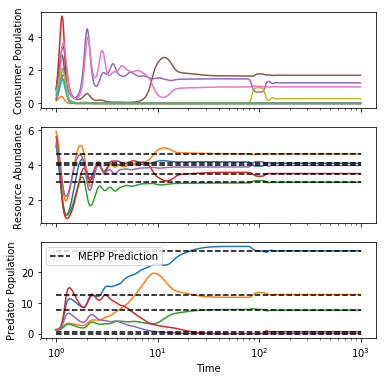

In [52]:
#Parameters
S = 10
MR = 5
MP = 5
params = {'c':np.random.rand(S,MR),
          'p':np.random.rand(S,MP),
          'm':np.random.rand(S)+1,
          'u':np.random.rand(MP)+1,
          'w':np.random.rand(MR)+1,
          'r':np.random.rand(MR)+1,
          'R0':np.random.rand(MR)+5}
N_init = np.random.rand(S)
R_init = params['R0']
P_init = np.random.rand(MP)+1
tmin = 1
tmax= 1000

#ODE
def dydt(t,y):
    N = y[:S]
    R = y[S:S+MR]
    P = y[S+MR:]
    dNdt = N*((params['c']*params['w']).dot(R)-params['p'].dot(P)-params['m'])
    dRdt = params['r']*R*(params['R0']-R) - (params['c'].T.dot(N))*R
    dPdt = (params['p'].T.dot(N))*P-params['u']*P
    return np.hstack((dNdt,dRdt,dPdt))
out_ODE = solve_ivp(dydt,(tmin,tmax),np.hstack((N_init,R_init,P_init)),t_eval=np.logspace(np.log10(tmin),np.log10(tmax),1000))
t = out_ODE.t
N = out_ODE.y[:S,:].T
R = out_ODE.y[S:S+MR,:].T
P = out_ODE.y[S+MR:,:].T

#Constrained optimization
noninvadable = LinearConstraint(np.hstack((params['c']*params['w'],-params['p'])),-np.inf*np.ones(S),params['m'])
resource_feasible = Bounds(0,np.inf)
def d(RP):
    R = RP[:MR]
    P = RP[MR:]                   
    return 0.5*((R-params['R0'])**2*params['w']*params['r']).sum() + params['u'].dot(P)
out_opt = minimize(d, np.hstack((R_init,P_init)), method='trust-constr', constraints=noninvadable, bounds=resource_feasible)
Rstar = out_opt.x[:MR]
Pstar = out_opt.x[MR:]

fig,ax=plt.subplots(3,sharex=True,figsize=(6,6))
#Plot ODE results
ax[0].semilogx(t,N)
ax[1].semilogx(t,R)
ax[2].semilogx(t,P)
#Plot optimization results
ax[1].plot([t[0],t[-1]],[Rstar,Rstar],'k--')
ax[2].plot([t[0],t[-1]],[Pstar,Pstar],'k--')
#Make legend
ax[2].plot([],[],'k--',label='MEPP Prediction')
ax[2].legend()
#Make labels
ax[2].set_xlabel('Time')
ax[0].set_ylabel('Consumer Population')
ax[1].set_ylabel('Resource Abundance')
ax[2].set_ylabel('Predator Population')
plt.show()

# Chemostat

\begin{align}
\frac{dN_i}{dt} &= N_i \left[ \sum_{\alpha} w_\alpha c_{i\alpha} R_\alpha - \tau^{-1}\right]\\
\frac{dR_\alpha}{dt} &= \tau^{-1} (R_\alpha^0 - R_\alpha) - \sum_i N_i c_{i\alpha} R_\alpha.
\end{align}

\begin{align}
d(\mathbf{R}^0,\mathbf{R}) &= \tau^{-1} \sum_\alpha w_\alpha\left[R_\alpha^0 \ln \frac{R_\alpha^0}{R_\alpha} - (R_\alpha^0 - R_\alpha)\right] \\
\sum_{\alpha} w_\alpha c_{i\alpha} R_\alpha &\leq \tau^{-1}
\end{align}

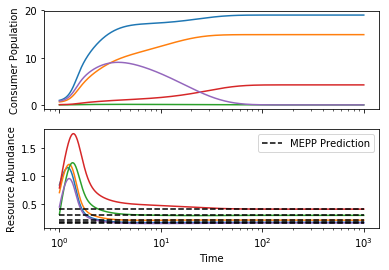

In [61]:
#Parameters
S = 5
M = 5
params = {'c':np.random.rand(S,M),
          'm':np.random.rand(S)+1,
          'w':np.random.rand(M)+1,
          'tau':1,
          'R0':np.random.rand(M)+5}
N_init = np.random.rand(S)
R_init = np.random.rand(M)
tmin = 1
tmax= 1000

#ODE
def dydt(t,y):
    N = y[:S]
    R = y[S:]
    dNdt = N*((params['c']*params['w']).dot(R)-1/params['tau'])
    dRdt = (params['R0']-R)/params['tau'] - (params['c'].T.dot(N))*R
    return np.hstack((dNdt,dRdt))
out_ODE = solve_ivp(dydt,(tmin,tmax),np.hstack((N_init,R_init)),t_eval=np.logspace(np.log10(tmin),np.log10(tmax),1000))
t = out_ODE.t
N = out_ODE.y[:S,:].T
R = out_ODE.y[S:,:].T

#Constrained optimization
noninvadable = LinearConstraint(params['c']*params['w'],-np.inf*np.ones(S),np.ones(S)/params['tau'])
resource_feasible = Bounds(0,np.inf)
def d(R):
    return params['w'].dot(kl_div(params['R0'],R))
def jac(R):
    return params['w']*(R-params['R0'])/R
def hess(R):
    return np.diag(params['w']*params['R0']/R**2)
out_opt = minimize(d, R_init, method='trust-constr', constraints=noninvadable, bounds=resource_feasible, jac=jac, hess=hess)
Rstar = out_opt.x

fig,ax=plt.subplots(2,sharex=True)
#Plot ODE results
ax[0].semilogx(t,N)
ax[1].semilogx(t,R)
#Plot optimization results
ax[1].plot([t[0],t[-1]],[Rstar,Rstar],'k--')
#Make legend
ax[1].plot([],[],'k--',label='MEPP Prediction')
ax[1].legend()
#Make labels
ax[1].set_xlabel('Time')
ax[0].set_ylabel('Consumer Population')
ax[1].set_ylabel('Resource Abundance')
plt.show()

# Saturating

\begin{align}
\frac{dN_i}{dt} &= N_i \left[\frac{e_i K_i \sum_\alpha w_\alpha c_{i\alpha}R_\alpha}{K_i + \sum_\alpha w_\alpha c_{i\alpha}R_\alpha} - m_i - \tau^{-1} \right]\\
\frac{dR_\alpha}{dt} &= \tau^{-1} (R_\alpha^0 - R_\alpha) - \sum_i N_i\frac{K_i c_{i\alpha}R_\alpha}{K_i+\sum_\beta w_\beta c_{i\beta}R_\beta}.
\end{align}

\begin{align}
d(\mathbf{R}^0,\mathbf{R}) &= \tau^{-1} \sum_\alpha w_\alpha\left[R_\alpha^0 \ln \frac{R_\alpha^0}{R_\alpha} - (R_\alpha^0 - R_\alpha)\right] \\
\frac{K_i \sum_\alpha w_\alpha c_{i\alpha}R_\alpha}{K_i + \sum_\alpha w_\alpha c_{i\alpha}R_\alpha}-m_i &\leq \tau^{-1}
\end{align}

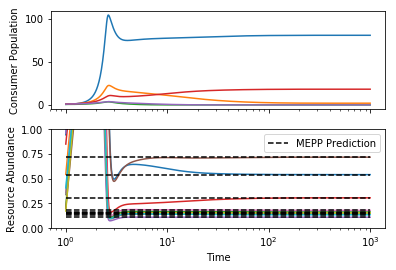

In [95]:
#Parameters
S = 5
M = 10
params = {'c':np.random.rand(S,M),
          'e':np.random.rand(S)+3,
          'm':np.random.rand(S)+1,
          'w':np.random.rand(M)+1,
          'K':np.random.rand(S)+1,
          'tau':1,
          'R0':np.random.rand(M)+5}
N_init = np.random.rand(S)
R_init = np.random.rand(M)
tmin = 1
tmax= 1000

#ODE
def g(R):
    return params['e']*params['K']*(params['c']*params['w']).dot(R)/(params['K']+(params['c']*params['w']).dot(R)) - params['m']
def g_jac(R):
    return ((params['c']*params['w']).T*params['K']**2*params['e']/(params['K']+(params['c']*params['w']).dot(R))**2).T
def g_hess(R,v):
    return np.einsum('i,ij,ik',-v*2*params['K']**2*params['e']/(params['K']+(params['c']*params['w']).dot(R))**3,params['c']*params['w'],params['c']*params['w'])
def dydt(t,y):
    N = y[:S]
    R = y[S:]
    dNdt = N*(g(R)-1/params['tau'])
    dRdt = (params['R0']-R)/params['tau'] - (params['c']*R).T.dot(params['K']*N/(params['K']+(params['c']*params['w']).dot(R)))
    return np.hstack((dNdt,dRdt))
out_ODE = solve_ivp(dydt,(tmin,tmax),np.hstack((N_init,R_init)),t_eval=np.logspace(np.log10(tmin),np.log10(tmax),1000))
t = out_ODE.t
N = out_ODE.y[:S,:].T
R = out_ODE.y[S:,:].T

#Constrained optimization
noninvadable = NonlinearConstraint(g,-np.inf,1/params['tau'],jac=g_jac,hess=g_hess)
resource_feasible = Bounds(0,np.inf)
def d(R):
    return params['w'].dot(kl_div(params['R0'],R))
def jac(R):
    return params['w']*(R-params['R0'])/R
def hess(R):
    return np.diag(params['w']*params['R0']/R**2)
out_opt = minimize(d, R_init, method='trust-constr', constraints=noninvadable, bounds=resource_feasible, jac=jac, hess=hess)
Rstar = out_opt.x

fig,ax=plt.subplots(2,sharex=True)
#Plot ODE results
ax[0].semilogx(t,N)
ax[1].semilogx(t,R)
#Plot optimization results
ax[1].plot([t[0],t[-1]],[Rstar,Rstar],'k--')
#Make legend
ax[1].plot([],[],'k--',label='MEPP Prediction')
ax[1].legend()
#Make labels
ax[1].set_xlabel('Time')
ax[0].set_ylabel('Consumer Population')
ax[1].set_ylabel('Resource Abundance')
ax[1].set_ylim((0,1))
plt.show()

# Liebig's Law

## Interactively essential resources

\begin{align}
\frac{dN_i}{dt} &= N_i \left[\left(\sum_\alpha \frac{1}{c_{i\alpha}^n R_\alpha^n}\right)^{-1/n} - \tau^{-1}\right]\\
\frac{dR_\alpha}{dt} &= \tau^{-1} (R_\alpha^0 - R_\alpha) - \sum_{i,\beta} N_i b_{\alpha\beta}\frac{1}{c_{i\beta}^nR_\beta^n} \left(\sum_\gamma \frac{1}{c_{i\gamma}^n R_\gamma^n}\right)^{-1/n-1}.
\end{align}

\begin{align}
d(\mathbf{R}^0,\mathbf{R}) &= \tau^{-1} \sum_\alpha \left[R_\alpha^0 \ln \frac{R_\alpha^0}{R_\alpha} - (R_\alpha^0 - R_\alpha)\right] \\
\tilde{R}_\alpha^0 &= R_\alpha^* + \sum_\beta (b^{-1})_{\alpha\beta}(R_\beta^0-R_\beta^*)\\
\left(\sum_\alpha \frac{1}{c_{i\alpha}^n R_\alpha^n}\right)^{-1/n}&\leq \tau^{-1}
\end{align}

Justification:
\begin{align}
q_{i\alpha} = - \sum_\beta b_{\alpha\beta}R_\beta\partial_\beta g
\end{align}

\begin{align}
-\partial_\alpha d = \sum_\beta (b^{-1})_{\alpha\beta}\frac{R_\beta^0 - R_\beta}{R_\alpha} \approx \frac{\tilde{R}_\alpha^0 - R_\alpha}{R_\alpha}
\end{align}

\begin{align}
\tilde{R}_\alpha^0 &= R_\alpha^* + \sum_\beta (b^{-1})_{\alpha\beta}(R_\beta^0-R_\beta^*)
\end{align}

\begin{align}
-\partial_\beta \partial_\alpha d = -(b^{-1})_{\alpha\beta}\frac{R_\beta^0}{R_\alpha}
\end{align}

\begin{align}
-\partial_\alpha \partial_\beta d = -(b^{-1})_{\beta\alpha}\frac{R_\alpha^0}{R_\beta}
\end{align}

## Essential resources

\begin{align}
\frac{dN_i}{dt} &= N_i \left[{\rm min}\left(\left\{c_{i\alpha} R_\alpha\right\}\right) - \tau^{-1}\right]\\
\frac{dR_\alpha}{dt} &= \tau^{-1} (R_\alpha^0 - R_\alpha) - \sum_{i} N_i b_{\alpha\beta_i} c_{i\beta_i}R_{\beta_i}
\end{align}

\begin{align}
d(\mathbf{R}^0,\mathbf{R}) &= \tau^{-1} \sum_\alpha \left[R_\alpha^0 \ln \frac{R_\alpha^0}{R_\alpha} - (R_\alpha^0 - R_\alpha)\right] \\
\tilde{R}_\alpha^0 &= R_\alpha^* + \sum_\beta (b^{-1})_{\alpha\beta}(R_\beta^0-R_\beta^*)\\{\rm min}\left(\left\{c_{i\alpha} R_\alpha\right\}\right) &\leq \tau^{-1}
\end{align}

In [ ]:
#Parameters
S = 6
M = 5
params = {'c':np.random.rand(S,M),
          'm':np.random.rand(S)+1,
          'b':np.random.rand(M,M)+1,
          'tau':1,
          'R0':np.random.rand(M)+5}
N_init = np.random.rand(S)
R_init = np.random.rand(M)
tmin = 1
tmax= 1000

#ODE
def g(R):
    return np.min(params['c']*R,axis=1)
def b(R):
    return np.asarray([params['b'][:,np.argmin(params['c'][k,:]*R)] for k in range(S)])
def g_jac(R):
    return np.asarray([params['c'][k,np.argmin(params['c'][k,:]*R)] for k in range(S)])
def g_hess(R,v):
    return np.zeros((M,M))
def dydt(t,y):
    N = y[:S]
    R = y[S:]
    dNdt = N*(g(R)-1/params['tau'])
    dRdt = (params['R0']-R)/params['tau'] - b(R).T.dot(g(R)*N)
    return np.hstack((dNdt,dRdt))
out_ODE = solve_ivp(dydt,(tmin,tmax),np.hstack((N_init,R_init)),t_eval=np.logspace(np.log10(tmin),np.log10(tmax),1000))
t = out_ODE.t
N = out_ODE.y[:S,:].T
R = out_ODE.y[S:,:].T

#Constrained optimization
noninvadable = NonlinearConstraint(g,-np.inf,1/params['tau'],jac=g_jac,hess=g_hess)
resource_feasible = Bounds(0,np.inf)
binv = np.linalg.inv(params['b'])
def d(R,Rstar):
    R0t = binv.dot(params['R0']-Rstar)+Rstar
    return np.ones(M).dot(kl_div(R0t,R))
def jac(R,Rstar):
    R0t = binv.dot(params['R0']-Rstar)+Rstar
    return (R-R0t)/R
def hess(R,Rstar):
    R0t = binv.dot(params['R0']-Rstar)+Rstar
    return np.diag(R0t/R**2)
out_opt = minimize(d, R_init, method='trust-constr', constraints=noninvadable, bounds=resource_feasible, jac=jac, hess=hess)
Rstar = out_opt.x

fig,ax=plt.subplots(2,sharex=True)
#Plot ODE results
ax[0].semilogx(t,N)
ax[1].semilogx(t,R)
#Plot optimization results
ax[1].plot([t[0],t[-1]],[Rstar,Rstar],'k--')
#Make legend
ax[1].plot([],[],'k--',label='MEPP Prediction')
ax[1].legend()
#Make labels
ax[1].set_xlabel('Time')
ax[0].set_ylabel('Consumer Population')
ax[1].set_ylabel('Resource Abundance')
plt.show()